<a href="https://colab.research.google.com/github/mvaldenegro/UncertaintyML-course-ESSAI-labs/blob/main/03_OOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/mvaldenegro/keras-uncertainty
!git clone https://github.com/mvaldenegro/UncertaintyML-course-ESSAI-labs

  Cloning https://github.com/mvaldenegro/keras-uncertainty to /tmp/pip-req-build-paq5dvgm
  Running command git clone --filter=blob:none --quiet https://github.com/mvaldenegro/keras-uncertainty /tmp/pip-req-build-paq5dvgm
  Resolved https://github.com/mvaldenegro/keras-uncertainty to commit ca332fd1006a8df7af2aea7375b608080eb7fd9e
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Uncertainty: filename=Keras_Uncertainty-0.0.1-py3-none-any.whl size=36625 sha256=7e188760c1c1a8647073e99d37f13ae4327282296f17c931f2802fe6d15075b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-sum26meq/wheels/0f/e9/fe/f6021c41f51978e09980019aa4b827d65ad4d3eca0c85be79a
Successfully built Keras-Uncertainty
Cloning into 'UncertaintyML-course-ESSAI-labs'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 41 (delta 15), reused 11 (delta 3), pack-reused 0
Receiving objects: 100% (41/41), 2.50 MiB |

In [ ]:
import keras
from keras import backend as K
import tensorflow as tf
import math

from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics as M
import pandas as pd
# from google.colab import files

import keras_uncertainty as ku



Keras Uncertainty will use standalone Keras backend

## Out-of-Distribution (OOD) Detection

ML models are trained on finite datasets which can encompass a finite variability of data.
Many of these models (especially NNs) are generally trained to produce highly-confident predictions even when presented with data which lies outside of the training distribution.

When referencing to NNs for image classification (e.g., cats vs dogs) we might have several situations when a well-trained model might fail:
* a model is presented with an image of a cat which is very different From the other cat images in the dataset (**unknown knowns**---the image comes from a known class, but the training dataset is not comprehensive enough to encompass for the sufficient variability of the data within this class).
* a model is presented with an image of a bird (**unkwnown unknows**---the image comes from a category which is **external** to the ones it was trained to recognize, but the model is not aware of the existence of other categories besides cat and dog).

OOD detection refers to the task of identifying whether some data do not overlap with the training distribution.
By adding some formalization, we call $\mathcal{X}$ the training distribution.
Let us call $\mathcal{U}$ the _universe_ distribution of the data type of the input of our model.
If our NN takes in images of size $h\times w$, we might think $\mathcal{U}$ as encompassing all possible images, i.e., all combinations of pixels in the range $[0-255]$.
The idea of OOD is to identify whether a test sample $x^\star$ comes from ${\mathcal{X}}$ or $\mathcal{U}\setminus{\mathcal{X}}$.


### A practical example of OOD failure with NNs

In the next code cells, we will be training a (frequentist) NN on MNIST and showcase a range of failures on some unknown unknowns and known unknowns.

In [ ]:
model_mnist = keras.Sequential([
    keras.layers.Input((28, 28, 1)), # data as image: heigth x width x channels. MNIST is grayscale » 1 channel
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10),
    keras.layers.Activation("softmax")
])

model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_mnist.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_data(data):
  '''
  Changes data type to float32, normalizes in [0,1] range, and add a channel singleton dimension
  '''
  return np.expand_dims(data.astype("float32"), -1) / 255

x = preprocess_data(x)
x_test = preprocess_data(x_test)

y = keras.utils.to_categorical(y, 10)
y_test = keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model_mnist.load_weights("/content/UncertaintyML-course-ESSAI-labs/files/nn_mnist_weights.keras")

In [ ]:
# Uncomment if you wish to train
# model_mnist.fit(x, y, batch_size=128, epochs=15)

Epoch 1/15
469/469 [==============================] - 9s 11ms/step - loss: 0.5091 - accuracy: 0.8582
Epoch 2/15
469/469 [==============================] - 3s 7ms/step - loss: 0.2253 - accuracy: 0.9352
Epoch 3/15
469/469 [==============================] - 3s 7ms/step - loss: 0.1793 - accuracy: 0.9486
Epoch 4/15
469/469 [==============================] - 3s 7ms/step - loss: 0.1509 - accuracy: 0.9560
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1308 - accuracy: 0.9622
Epoch 6/15
469/469 [==============================] - 3s 7ms/step - loss: 0.1148 - accuracy: 0.9666
Epoch 7/15
469/469 [==============================] - 3s 7ms/step - loss: 0.1036 - accuracy: 0.9687
Epoch 8/15
469/469 [==============================] - 5s 10ms/step - loss: 0.0954 - accuracy: 0.9714
Epoch 9/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0860 - accuracy: 0.9746
Epoch 10/15
469/469 [==============================] - 3s 6ms/step - loss: 0.0808 - accuracy: 0.97

In [ ]:
# uncomment to save weights and load files
# model_mnist.save_weights("nn_mnist_weights.keras")
# files.download("nn_mnist_weights.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This is Keras' default way to assess a model.

In [ ]:
model_mnist.evaluate(x_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.1059 - accuracy: 0.9698


[0.10594726353883743, 0.9697999954223633]

**Q: _despite the above function working correctly, we are missing something very useful for our labs. What?_**

In [ ]:
mnist_test_predictions = model_mnist.predict(x_test)
mnist_test_correct_predictions = (mnist_test_predictions.argmax(axis=1) == y_test.argmax(axis=1))
mnist_test_accuracy = mnist_test_correct_predictions.mean()
mnist_test_accuracy

313/313 [==============================] - 0s 910us/step


0.9698

Let's now evaluate our model with a randomly generated image within the $[0-1]$ range

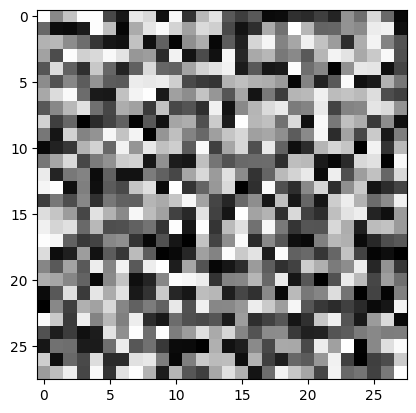

In [ ]:
random_image = np.random.rand(28,28)
plt.imshow(random_image, cmap="gray")

In [ ]:
def predict_and_plot(image, model, normalize=False):
  if normalize:
    image = image / 255
  model_output = model.predict(image)
  _=plt.bar(x=np.arange(0,10), height=model_output.squeeze())
  _=plt.xticks(np.arange(0,10))

1/1 [==============================] - 0s 15ms/step


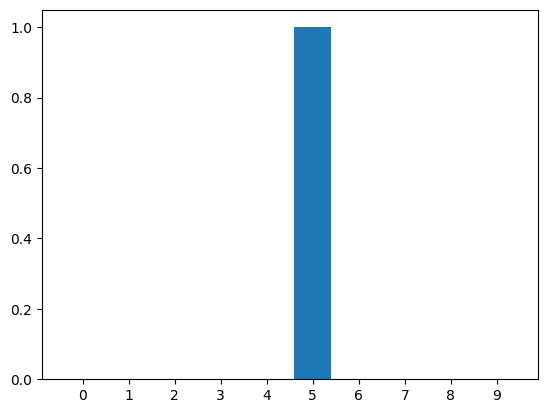

In [ ]:
predict_and_plot(np.expand_dims(random_image, (0, -1)), model_mnist)

**Q: _The above image is an example of..._**
1. **_known known_**
2. **_unknown known_**
3. **_known unknown_**
4. **_unknown unknown_**


**Q: _What can you say on the behavior of the model in this case?_**



Let's try with another example...

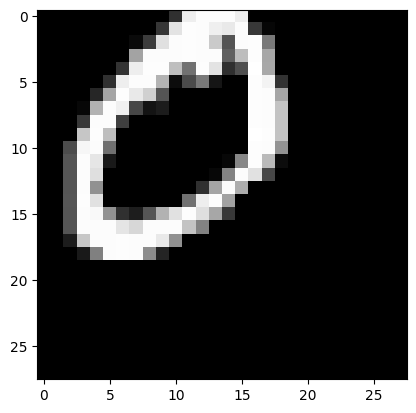

In [ ]:
shifted_img = np.zeros((28,28,1))
shifted_img[:20,:21] = x[1,5:25,4:25] / 255
plt.imshow(shifted_img, cmap="gray")

1/1 [==============================] - 0s 38ms/step


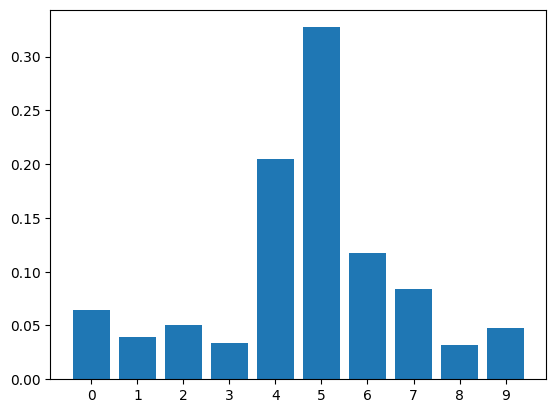

In [ ]:
predict_and_plot(np.expand_dims(shifted_img, 0), model_mnist)

**Q: _Can you comment on the behavior of the model for this specific image? Is it a case of unknown known or unknown unknown? Do you think the image is really OOD, or is the failure of the model here a case of bad model selection/bad inductive biases?_**

## Assessing OOD detection capability

Assessing OOD detection capability is a hard task.
Multiple things need to be taken into consideration while deciding the dataset for assessing it:
1. The domain for OOD model is huge, potentially infinite: it's thus impossible to obtain a comprehensive dataset for exhaustively evaluate the potential of the model on OOD detection
2. What is the level of _similarity_ needed between the training dataset and the dataset for assessing OOD detection? In most applications, we might want to get a dataset where the datapoints are _sufficiently similar_ to the data in the trainset, data that the model could encounter while being tested or deployed. For instance, if we train a model to classify paintings, it's probably useless to assess it against images from MNIST or CIFAR10. In other words, the domain of the data should be similar and plausible for the application.

In our case, we will compare our model trained on MNIST against data from Fashion-MNIST. This is a standard OOD test in the literature, especially for toy examples, since (a) both data are natively produced at the same resolution (28x28 pixels) and with similar domain (the images contain grayscale examples of handwritte digits/fashion products and the background is always plain black; in addition, the images contain only the object to be classified, unlike other popular image datasets which contain natural images), and (b) there is no overlap between the classes of MNIST and Fashion MNIST, which makes it the perfect model to evaluate the confidence of the model when being evaluated with unknown unknowns.

![data from Fashion MNIST](https://storage.googleapis.com/kaggle-datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png)

We first download the Fashion MNIST dataset using keras API:

In [ ]:
_, (x_ood, y_ood) = tf.keras.datasets.fashion_mnist.load_data()
x_ood = preprocess_data(x_ood)

4422102/4422102 [==============================] - 0s 0us/step


**Q: *What does the `_` mean in the expression `_, (x_ood, y_ood) = tf...`? Why is it there?***

We then proceed to evaluate the new data on our keras model, producing the predictions.

In [ ]:
fmnist_predictions = model_mnist.predict(x_ood)

313/313 [==============================] - 0s 1ms/step


**Q: _What does the variable `fmnist_predictions` contain?_**

We then obtain the confidence value associated to the highest prediction for both MNIST and Fashion MNIST.

The confidence value can be obtained both from the logits (pre-softmax) and from the probability values (post-softmax).
Usually, working with the logits yields better results for OOD detection. **Can we get them directly?**

In [ ]:
mnist_test_confidence = # your code here
fmnist_confidence = # your code here

We can immediately compare the two distribution using a visualization method like a boxplot (also density/violin plots are perfectly fine for this task). In the figure below, "1" on the x-axis refers to MNIST, "2" to Fashion MNIST, while the y axis tracks the confidence.

(0.0, 1.0)

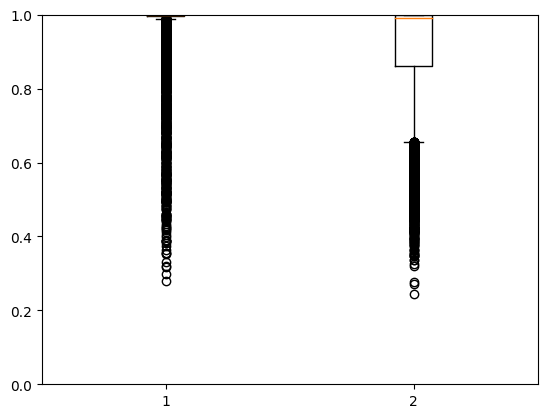

In [ ]:
_ = plt.boxplot([mnist_test_confidence, fmnist_confidence])
plt.ylim((0,1))

**Q: _What can you comment on the above chart? What are the main differences between the two distributions?_**

We can quantitatively check the model capability for telling apart ID and OOD data by using the confidence values as _predictors_ for OOD.
We can do so by assigning a synthetic label of 0 for ID data (MNIST) and 1 for OOD data (Fashion MNIST) and see if we can find a confidence threshold which optimally divides the two distributions.
We can measure the performance using one or more metrics for binary classification:
* Accuracy
* FP and/or FN
* F1 score
* ...

**_Other ideas_**?

In [ ]:
def ood_detection_scores(confidence_id, confidence_ood,
                         min_thresh=0.0, max_thresh=1.0, num_steps=101,
                         comparison_fn=np.less):

  ood_label = np.concatenate([
      np.zeros_like(confidence_id),
      np.ones_like(confidence_ood)
  ])

  len_id = len(confidence_id)

  threshold = []
  accuracy = []
  accuracy_id = []
  accuracy_ood = []
  f1_score = []
  # add here other metrics

  for thresh in np.linspace(min_thresh, max_thresh, num_steps):
    detection_scores_id = np.where(comparison_fn(confidence_id, thresh), 1, 0)
    detection_scores_ood = np.where(comparison_fn(confidence_ood, thresh), 1, 0)
    detection_scores = np.concatenate([detection_scores_id, detection_scores_ood])

    acc = M.accuracy_score(ood_label, detection_scores)
    acc_id = M.accuracy_score(ood_label[:len_id], detection_scores_id)
    acc_ood = M.accuracy_score(ood_label[len_id:], detection_scores_ood)
    f1 = M.f1_score(ood_label, detection_scores)
    # add here other metrics

    threshold.append(thresh)
    accuracy.append(acc)
    accuracy_id.append(acc_id)
    accuracy_ood.append(acc_ood)
    f1_score.append(f1)
    # add here other metrics

  ood_detection_scores = pd.DataFrame({
    "threshold": threshold,
    "accuracy": accuracy,
    "accuracy_id": accuracy_id,
    "accuracy_ood": accuracy_ood,
    "f1_score": f1_score,
    # add here other metrics
  })

  return ood_detection_scores

In [ ]:
ood_detection_scores(mnist_test_confidence, fmnist_confidence)

,threshold,accuracy,accuracy_id,accuracy_ood,f1_score
0,0.00,0.50000,1.0000,0.0000,0.000000
1,0.01,0.50000,1.0000,0.0000,0.000000
2,0.02,0.50000,1.0000,0.0000,0.000000
3,0.03,0.50000,1.0000,0.0000,0.000000
4,0.04,0.50000,1.0000,0.0000,0.000000
...,...,...,...,...,...
96,0.96,0.68620,0.8988,0.4736,0.601473
97,0.97,0.69355,0.8853,0.5018,0.620848
98,0.98,0.69855,0.8639,0.5332,0.638831
99,0.99,0.70150,0.8200,0.5830,0.661373


Another common indicator for measuring the _separability_ power of a classifier is the Receiving Operator Curve (ROC) and the corresponding Area Under the Curve (AUC, but often called AUROC or AUC-ROC).
This metric already scans the separability for a multeplicity of thresholds. A perfect separability yields a value of 1.

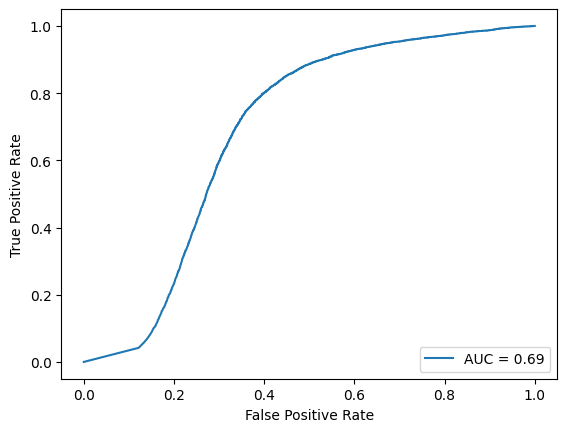

In [ ]:
def plot_roc(confidence_id, confidence_ood):
  ood_label = np.concatenate([
        np.zeros_like(confidence_id),
        np.ones_like(confidence_ood)
    ])

  true_pos_rate, false_pos_rate, thresh = M.roc_curve(
      ood_label,
      np.concatenate([confidence_id, confidence_ood])
  )
  roc_auc = M.auc(false_pos_rate, true_pos_rate)

  display = M.RocCurveDisplay(fpr=false_pos_rate, tpr=true_pos_rate, roc_auc=roc_auc)
  display.plot()

plot_roc(mnist_test_confidence, fmnist_confidence)

### Do we get any improvement if we switch to Entropy?

We have made considerations on the confidence in the prediction:

$$
\text{Conf}(\hat{y}) = \max_{c=1,\dots,C} \hat{y}
$$

However, we could also make considerations on the **Entropy** of the prediction

$$
H(\hat{y}) = -\sum_{c=1}^{C} \hat{y}_c \log \hat{y}_c
$$

In [ ]:
def entropy(predictions_array):
  # your code here
  pass

In [ ]:
entropy_mnist_test = # pass
entropy_fmnist = # pass

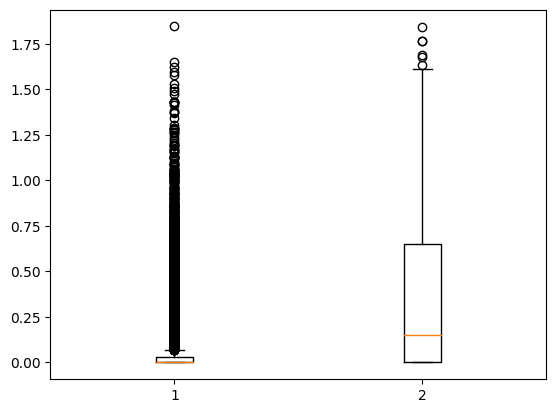

In [ ]:
_ = plt.boxplot((entropy_mnist_test, entropy_fmnist))

In [ ]:
ood_detection_scores(entropy_mnist_test, entropy_fmnist,
                     max_thresh=max(entropy_mnist_test.max(), entropy_fmnist.max()),
                     comparison_fn=np.greater)

,threshold,accuracy,accuracy_id,accuracy_ood,f1_score
0,0.000000,0.50000,0.0000,1.0000,0.666667
1,0.018457,0.68145,0.7029,0.6600,0.674467
2,0.036913,0.69785,0.7761,0.6196,0.672200
3,0.055370,0.70010,0.8096,0.5906,0.663223
4,0.073827,0.70030,0.8343,0.5663,0.653926
...,...,...,...,...,...
96,1.771846,0.50000,0.9999,0.0001,0.000200
97,1.790303,0.50000,0.9999,0.0001,0.000200
98,1.808760,0.50000,0.9999,0.0001,0.000200
99,1.827216,0.50000,0.9999,0.0001,0.000200


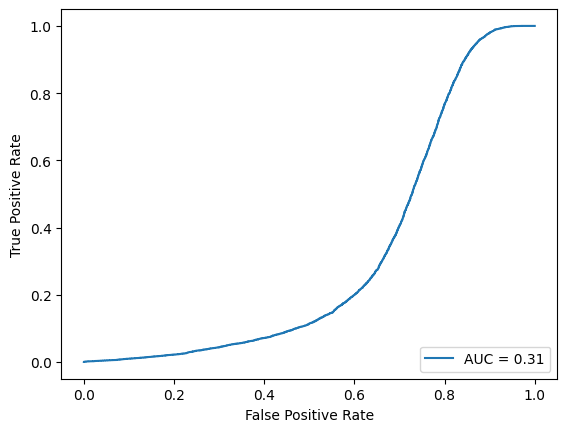

In [ ]:
plot_roc(entropy_mnist_test, entropy_fmnist)

## Switch to a Bayesian model

We have seen that the deterministic NN is unable to effectively tell apart ID and OOD, despite the confidence of the OOD data having a distribution more skewed toward smaller values w.r.t. the ID data.

We can repeat the experiment with a BNN and see if this model is more effective at detecting OOD data.

In [ ]:
bnn_backbone_mnist = keras.Sequential([
    keras.layers.Input((28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    ku.layers.StochasticDropout(0.2),
    keras.layers.Dense(32, activation="relu"),
    ku.layers.StochasticDropout(0.2),
    keras.layers.Dense(10, activation="softmax")
])

bnn_backbone_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# uncomment to train
# bnn_backbone_mnist.fit(x, y, batch_size=128, epochs=35)

In [ ]:
bnn_backbone_mnist.load_weights("/content/UncertaintyML-course-ESSAI-labs/files/bnn_dropout_mnist_weights.keras")

# bnn_backbone_mnist.save_weights("bnn_dropout_mnist_weights.keras")
# files.download("bnn_dropout_mnist_weights.keras")

In [ ]:
bnn_mnist = ku.models.StochasticClassifier(bnn_backbone_mnist)

Get the predictions... This might take a while, so I have saved them and I can provide them already pre-packaged in a numpy archive.

In [ ]:
# Uncomment to get predictions
# mnist_test_predictions_bnn = bnn_mnist.predict(x_test, num_samples=25)

In [ ]:
mnist_test_predictions_bnn = np.load(
    "/content/UncertaintyML-course-ESSAI-labs/files/bnn_dropout_mnist_predictions.npy"
)

In [ ]:
# np.save("bnn_dropout_mnist_predictions.npy", mnist_test_predictions_bnn)
# files.download("bnn_dropout_mnist_predictions.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Uncomment to get predictions
# fmnist_predictions_bnn = bnn_mnist.predict(x_ood, num_samples=25)

In [ ]:
fmnist_predictions_bnn = np.load(
    "/content/UncertaintyML-course-ESSAI-labs/files/bnn_dropout_fmnist_predictions.npy"
)

In [ ]:
# np.save("bnn_dropout_fmnist_predictions.npy", fmnist_predictions_bnn)
# files.download("bnn_dropout_fmnist_predictions.npy")#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As we did with the deterministic model, we define the confidence as the maximum value of probability associated with the predicted class.

**Q: _what is the difference in the predictions between the deterministic and the Bayesian model (`mnist_test_predictions` vs `mnist_test_predictions_bnn`)?_**

In [ ]:
mnist_confidence_bnn = # your code here
fmnist_confidence_bnn = # your code here

Again, as we did before, we define the `ood_label` to treat as ground truth, create a single vector for the confidence levels, and analyze the accuracy and F1-scores.

In [ ]:
ood_label = np.concatenate([
    np.zeros_like(mnist_confidence_bnn),
    np.ones_like(fmnist_confidence_bnn)
])
confidence_bnn = np.concatenate([
    mnist_confidence_bnn, fmnist_confidence_bnn
])

In [ ]:
ood_detection_scores(mnist_confidence_bnn, fmnist_confidence_bnn)

,threshold,accuracy,accuracy_id,accuracy_ood,f1_score
0,0.00,0.50000,1.0000,0.0000,0.000000
1,0.01,0.50000,1.0000,0.0000,0.000000
2,0.02,0.50000,1.0000,0.0000,0.000000
3,0.03,0.50000,1.0000,0.0000,0.000000
4,0.04,0.50000,1.0000,0.0000,0.000000
...,...,...,...,...,...
96,0.96,0.75170,0.6014,0.9020,0.784143
97,0.97,0.72535,0.5322,0.9185,0.769811
98,0.98,0.68380,0.4327,0.9349,0.747262
99,0.99,0.62590,0.2988,0.9530,0.718107


And we compute the ROC and calculate the AUROC


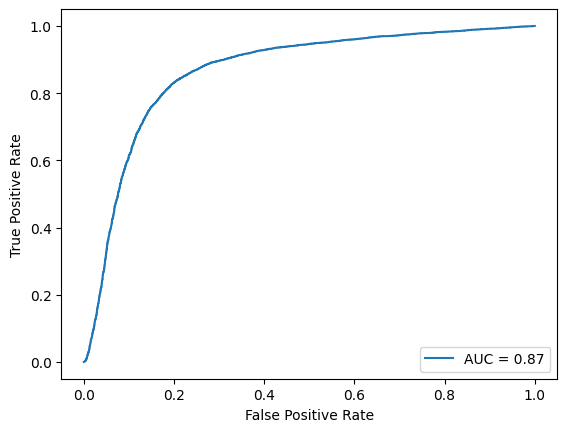

In [ ]:
plot_roc(mnist_confidence_bnn, fmnist_confidence_bnn)

We can also visualize the difference with the boxplots, as we did before

(0.0, 1.0)

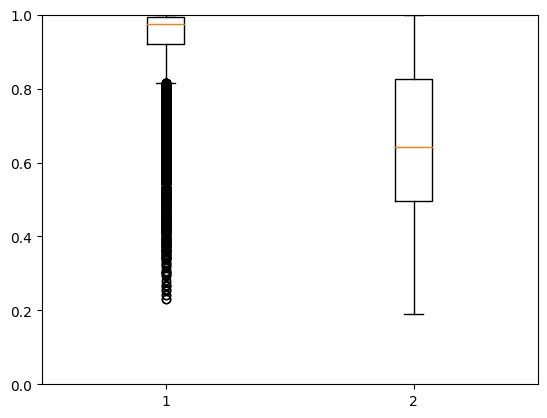

In [ ]:
_ = plt.boxplot([mnist_confidence_bnn, fmnist_confidence_bnn])
plt.ylim((0,1))

**Your task**: repeat this analysis with entropy. Does something change in the metrics for OOD detection?

## Variational Inference

We can also try and have a look at the behavior of a model with VI. VI tends to be slower to learn w.r.t. other Bayesian methods, so we will utilize a different MLP architecture with more neurons, and train for a longer time.

In [ ]:
bsize = 128
kl_weight = 1

vi_backbone_mnist = keras.Sequential([
    keras.layers.Input((28, 28, 1)),
    keras.layers.Flatten(),
    ku.layers.VariationalDense(64, kl_weight=kl_weight, activation="relu"),
    ku.layers.VariationalDense(64, kl_weight=kl_weight, activation="relu"),
    ku.layers.VariationalDense(10, kl_weight=kl_weight, activation="softmax")
])

vi_backbone_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Uncomment to train
# vi_backbone_mnist.fit(x, y, batch_size=128, epochs=35)

In [ ]:
vi_backbone_mnist.load_weights(
    "/content/UncertaintyML-course-ESSAI-labs/files/bnn_vi_mnist_weights.keras"
)

In [ ]:
vi_mnist = ku.models.StochasticClassifier(vi_backbone_mnist)
# Uncomment to get predictions
# mnist_test_predictions_vi = vi_mnist.predict(x_test, num_samples=25)
mnist_test_predictions_vi = np.load(
    "/content/UncertaintyML-course-ESSAI-labs/files/bnn_vi_mnist_predictions.npy"
)

In [ ]:
# Uncomment to get predictions
# fmnist_predictions_vi = vi_mnist.predict(x_ood, num_samples=25)
fmnist_predictions_vi = np.load(
    "/content/UncertaintyML-course-ESSAI-labs/files/bnn_vi_fmnist_predictions.npy"
)

As for MCDropout, let's get the confidence...

In [ ]:
mnist_confidence_vi = # your code here
fmnist_confidence_vi = # your code here

In [ ]:
# Uncomment to save
# np.save("mnist_test_predictions_vi.npy", mnist_test_predictions_vi)
# np.save("fmnist_predictions_vi.npy", fmnist_predictions_vi)
# files.download("mnist_test_predictions_vi.npy")
# files.download("fmnist_predictions_vi.npy")

In [ ]:
ood_label = np.concatenate([
    np.zeros_like(mnist_confidence_vi),
    np.ones_like(fmnist_confidence_vi)
])
confidence_vi = np.concatenate([
    mnist_confidence_vi, fmnist_confidence_vi
])

In [ ]:
ood_detection_scores(mnist_confidence_vi, fmnist_confidence_vi)

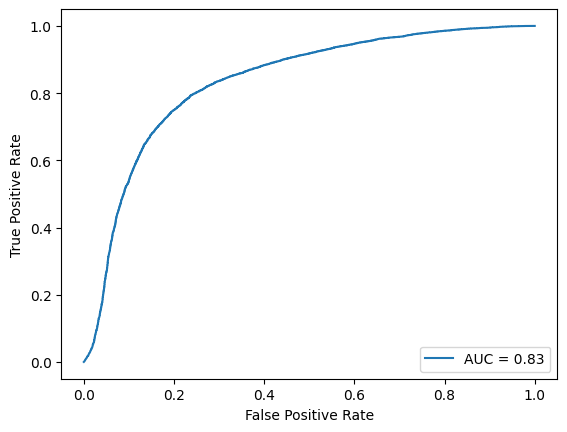

In [ ]:
plot_roc(mnist_confidence_vi, fmnist_confidence_vi)

## ODIN

[ODIN](https://arxiv.org/pdf/1706.02690.pdf) is a method for OOD detection which is based upon the aforementioned concept of confidence, with the addition of **temperature scaling**.

Let us call the output of our model pre-softmax $f(x)$ for a generic input $x$.
We know that $f(x)$ has $C$ components, where $C$ is the number of classes:
$$
f(x) = \left[f_1(x),\dots,f_C(x)\right]^\top
$$

Our prediction $\hat{y}$ is obtained as $\text{softmax}(f(x))$. For a generic component $c\in\{1,\dots,C\}$ we have
$$
\text{softmax}(f_c(x)) = \frac{e^{f_c(x)}}{\sum_{k=1}^C e^{f_k(x)}}.
$$
This turns $f(x)$ into a simplex $\hat{y}$, i.e., a vector interpretable as a probability distribution.

The softmax can be generalized by adding a parameter $T$ called **temperature**:
$$
\text{softmax}(f_c(x), T) = \frac{e^{f_c(x)/T}}{\sum_{k=1}^C e^{f_k(x)/T}}.
$$
The effect of $T$ is to increase or decrease the entropy of the prediction.
$T<1$ decreases the entropy, thus increasing the confidence in the argmax category; $T>1$ increases the entropy, thus decreasing the confidence.

ODIN acts as a post-hoc OOD detection method (**Q: _what am I referring to when I talk about post-hoc?_**) which acts by:
* modifying the predictions by means of a softmax with very high temperature ($T>100$) and
* using the corresponding confidence to drive the OOD detection.

**Your task**: implement ODIN with the aforementioned strategy on the deterministic model trained on MNIST.
If you do everything correctly, no re-training should be done.
Once you have implemented the softmax with temperature and obtained the modified predictions, you should tune the temperature and the confidence threshold to find the optimal values for OOD detection.
For $T$, you could pick $k$ values between 100 and 1500, for instance.

_Tips_:
* You should be able to re-use the `ood_detection_scores` function, with a few modifications.
* You will need to access the output of the model pre-softmax, i.e., you need to access the intermediate output of the model. In Keras, this can be done in the following way:

In [ ]:
pre_softmax_extractor = keras.Model(
    inputs=model_mnist.inputs,
    outputs=model_mnist.layers[-2].output
)

pre_softmax_data = pre_softmax_extractor(x_test)

Essentially, we build a `Model` on top of our `model_mnist` which _intercepts_ the output of the penultimate layer (the final being the softmax).

Be careful that the output of `pre_softmax_extractor` is a TF Tensor, not a NumPy array. You can easily convert the Tensor to an array by calling the `.numpy()` method on the Tensor.

In [ ]:
# your code here

**Extra task (for the more ambitious ones)**

ODIN is not only about temperature scaling.
It also adds an initial preprocessing step on the image, which aims at adding a small perturbation before obtaining the final softmax. The perturbation is calculated as

$$
d(x) = \epsilon\cdot\text{sgn}(-\nabla_x \hat{y}).
$$

In the formula above:
* $\nabla_x$ identifies the gradient of the softmax $\hat{y}$ w.r.t. the image $x$
* $\text{sgn}$ is the sign function:
  $$
  \text{sgn}(a) = \begin{cases} 1 & \text{if } a>0 \\ -1 &  \text{otherwise}\end{cases}
  $$

__Tips__: for this, you're gonna need to use TF.
This is the basic code snippet for calculating gradients of a quantity w.r.t. a variable `x`:

```python
x = tf.Variable(...) # here is e.g. a batch of test images

with tf.GradientTape() as tape:
  y = some_computation(x)

grad_x = tape.gradient(y, x)
```